## Маски рек

In [1]:
import pandas as pd
import os
import cv2
import numpy as np
from PIL import Image, ImageEnhance, ImageEnhance, ImageGrab, ImageOps
import matplotlib.pyplot as plt
import tifffile
from dataclasses import dataclass
from sklearn.neighbors import NearestNeighbors

In [2]:
base_path = r"C:\Users\Maria Smirnova\Desktop\Проекты\LDT"

In [3]:
mask_key_word = 'layout'
files_format = ['tif']

images = [] 
masks = []
for address, dirs, files in os.walk(base_path):
    #print(address, dirs, files)
    for f in files:
            if f.endswith('tif'):
                file_path = os.path.join(address, f)
                if (mask_key_word in f):
                    if f  == 'layout_2021-08-16.tif':
                        #masks.append(Image.open(file_path))
                        mask = tifffile.imread(file_path)
                        masks.append(mask)
                else:
                    #images.append(Image.open(file_path))
                    #images.append(Scene(tifffile.imread(file_path), 0))
                    images.append(tifffile.imread(file_path))

print('Количество изображений:', len(images), '\nКоличество масок:', len(masks))


Количество изображений: 20 
Количество масок: 1


In [4]:
def row_img_to_layers(img):
    norm_coef = 90
    r = normalize_channel(img[:,:,0], norm_coef)
    g = normalize_channel(img[:,:,1], norm_coef)
    b = normalize_channel(img[:,:,2], norm_coef)
    nir = normalize_channel(img[:,:,3], norm_coef)
    return r, g, b, nir

def hist_equalization(channel:np.array) -> np.array:
    if len(channel.shape) > 2:
        print(channel.shape[len(channel.shape)-1])
        channel = cv2.cvtColor(channel, cv2.COLOR_BGR2GRAY)
    channel = cv2.equalizeHist(channel)
    return channel

def normalize_channel(channel: np.array, perc_thr: int = 100, lower_pecr_thr: int = 2) -> np.array:
    '''
    Get's (h, w, 1) - channel-layer, pecentage to cut histogram
    return normalize and cut data
    '''
    perc_rows = np.percentile(channel, perc_thr, axis=1)
    perc_cols = np.percentile(channel, perc_thr, axis=0)
    thr = max(np.max(perc_rows), np.max(perc_cols))

    lower_pecr_thr = 2
    perc_rows = np.percentile(channel, lower_pecr_thr, axis=1)
    perc_cols = np.percentile(channel, lower_pecr_thr, axis=0)
    thr_min = min(np.min(perc_rows), np.min(perc_cols))

    channel[channel > thr] = thr
    #l[l > thr] = np.mean(l)
    channel[channel < thr_min] = thr_min
    if np.max(channel) !=0:
        channel = channel/np.max(channel)
    channel = channel*255 # приводим к 0 255
    channel = channel.astype(np.uint8)
    return channel

def normalize(image: np.array, perc_thr: int = 100, lower_pecr_thr: int = 2) -> np.array:
    '''
    Get's (h, w, 1) - image, pecentage to cut histogram
    return normalize image
    '''
    channel = np.nan
    for i in range(len(image.shape)):
        if image.shape[i] == len(image.shape):
            channel == i
    r = normalize_channel(image[:, :, 0], perc_thr, lower_pecr_thr)
    g = normalize_channel(image[:, :, 1], perc_thr, lower_pecr_thr)
    b = normalize_channel(image[:, :, 2], perc_thr, lower_pecr_thr)
    nir = normalize_channel(image[:, :, 3], perc_thr, lower_pecr_thr)
    if channel == 0:
        r = normalize_channel(image[0, :, :], perc_thr, lower_pecr_thr)
        g = normalize_channel(image[1 :, :], perc_thr, lower_pecr_thr)
        b = normalize_channel(image[2, :, :], perc_thr, lower_pecr_thr)
        nir = normalize_channel(image[3, :, :], perc_thr, lower_pecr_thr)
    image = np.dstack((r, g, b, nir))
    return image

def imshow(image: np.array, bands: str, hist_equal: bool = False):
    '''
    Function get images as np.array 
    and bands neeeded to show (1 to 3), expl: r, nir, d
    and print it
    '''
    channel = np.nan
    for i in range(len(image.shape)):
        if image.shape[i] == len(image.shape):
            channel == i
    r = normalize_channel(image[:, :, 0])
    g = normalize_channel(image[:, :, 1])
    b = normalize_channel(image[:, :, 2])
    nir = normalize_channel(image[:, :, 3])
    if channel == 0:
        r = normalize_channel(image[0, :, :])
        g = normalize_channel(image[1 :, :])
        b = normalize_channel(image[2, :, :])
        nir = normalize_channel(image[3, :, :])
            
    chn_dict = {'r':r, 'g':g, 'b':b, 'nir':nir}

    if hist_equal:
        for key in list(chn_dict.keys()):
            chn_dict[key] = hist_equalization(chn_dict[key])

    b_list = []
    for b in bands.split(', '):
        b_list.append(chn_dict[b])
    
    img = np.dstack(b_list)
    plt.imshow(img)
    plt.show()

def normalized_filtered(image: np.array, bands: str, hist_equal: bool = False):
    '''
    The same as imshow(), but return np.array
    '''
    channel = np.nan
    for i in range(len(image.shape)):
        if image.shape[i] == len(image.shape):
            channel == i
    r = normalize_channel(image[:, :, 0])
    g = normalize_channel(image[:, :, 1])
    b = normalize_channel(image[:, :, 2])
    nir = normalize_channel(image[:, :, 3])
    if channel == 0:
        r = normalize_channel(image[0, :, :])
        g = normalize_channel(image[1 :, :])
        b = normalize_channel(image[2, :, :])
        nir = normalize_channel(image[3, :, :])
            
    chn_dict = {'r':r, 'g':g, 'b':b, 'nir':nir}

    if hist_equal:
        for key in list(chn_dict.keys()):
            chn_dict[key] = hist_equalization(chn_dict[key])

    b_list = []
    for b in bands.split(', '):
        b_list.append(chn_dict[b])
    
    img = np.dstack(b_list)
    return img


In [5]:
# показывает растительность
def calcus_NDVI(r:np.array, nir:np.array, masking:bool = False) -> np.array:
    NDVI = (nir - r)/(nir +r)
    NDVI[NDVI>1] = 1
    NDVI[NDVI<-1] = -1
    if masking:
        NDVI[NDVI>=0.7] = 4
        NDVI[(NDVI>=0.4)&(NDVI<0.7)] = 3
        NDVI[(NDVI>=0)&(NDVI<0.4)] = 2
        NDVI[(NDVI>=-1)&(NDVI<0)] = 1
    return NDVI

# оптимизированный NDVI, учитывает атмосферные воздыейтсви и фоновый сигнал раст., не становится оч насыщенным
def calcus_EVI(r, b, nir, masking:bool = False):
    EVI = 2.5*((nir - r)/(nir + 6*r - 7.5*b + 1))
    EVI[EVI>10] = 10
    EVI[EVI<-5] = -5
    if masking:
        EVI[EVI<-2.1] = -100
        EVI[(EVI>=-2.1)&(EVI<0)] = -200 
        EVI[(EVI>=0)&(EVI<8)] = -300
        EVI[EVI>=8] = -400
        EVI = EVI/(-100) 
    return EVI

# индекс фотосинтетической активности растительного покрова
def calcus_GNDVI(g, nir, masking=False):
    GNDVI = (nir-g)/(nir+g)
    GNDVI[GNDVI>1] = 1
    GNDVI[GNDVI<-1] = -1
    if masking:
        GNDVI[GNDVI<0.35] = 100
        GNDVI[(GNDVI>=0.35) & (GNDVI<0.57)] = 200
        GNDVI[(GNDVI>=0.57) & (GNDVI<=1)] = 300
        GNDVI = GNDVI/100
    return GNDVI

# концентрация хлорофила, оч. зависит от времени года
def calcus_MCARI(r,g,nir):
    MCARI = (1.5*(2.5*(nir - r) - 1.3*(nir - g)))/np.sqrt((2*nir + 1)**2 - (6*nir - 5*np.sqrt(r))) - 5
    MCARI[MCARI>10] = np.nan
    MCARI[MCARI<-4] = np.nan
    return MCARI

# индекс мутности воды, слабо резает
def calcus_NDTI(r,g, masking=False):
    NDTI = (r-g)/(r+g)
    if masking:
        NDTI[NDTI<60] = 1
        NDTI[(NDTI>=60)&(NDTI<80)] = 2
        NDTI[NDTI>=80] = 3
    return NDTI

#ration vegetation index 
def calcus_RVI(r, nir, masking=False):
    if r.any() == 0:
        r = 1
    RVI = nir/r
    if masking:
        RVI[RVI<2.5] = 1
        RVI[(RVI>=2.5)&(RVI<4.0)] = 2
        RVI[(RVI>4.0)&(RVI<10)] = 3
        RVI[RVI>=10] = 4
    return RVI

# Kauth-Thomas transformation Tasseled Cap
# Используем ИК без разделения, в оригнале ИК делится по волнам: 07,-08/ 0,8-1,1
def calcus_tasseled_cap(r,g, nir, masking=False):
    # яркость, связана с измненеиями в почве
    b = 0.433*g + 0.632*r + 0.586*nir + 0.264*nir +32
    # зелёность, связана с зелёной растительность, похожа на вегетационный индекс
    g = -0.290*g-0.562*r+0.600*nir+0.491*nir +32
    # желтость, старением растений
    y = -0.829*g +0.522*r-0.039*nir +0.197*nir +32
    # nonesuch
    n = 0.233*g+0.012*r-0.543*nir +0.810*nir +32
    tass_cap = np.dstack((b, g, y, n))
    if masking:
        tass_cap[tass_cap<-2000] = -10000
        tass_cap[(tass_cap>=-2000)&(tass_cap<0)] = -20000
        tass_cap[(tass_cap>=0)&(tass_cap<1800)] = -30000
        tass_cap[(tass_cap>=1800)&(tass_cap<3700)] = -40000
        tass_cap[tass_cap>=3500] = -50000
        tass_cap = tass_cap/(-10000)
    return tass_cap



#normalized diffference snow index
# НЕ ИСПОЛЬЗУЕМ 
#вместо коротковолнового ИК, просто ИК
def calcus_NDSI(g, nir):
    NDSI = (g-nir)/(g+nir)
    return NDSI

#normalized defference water index
def calcus_NDWI(g, nir, masking=False):
    NDWI = (g-nir)/(g+nir)
    if masking:
        NDWI[NDWI<26] = 1
        NDWI[(NDWI>=26)&(NDWI<42)] = 2
        NDWI[(NDWI>=42)] = 3
    return NDWI

In [6]:
def get_mean_neighbours(image, channel: int, x: int, y: int) -> int:
        neighbours = []
        rows, cols = image.shape[:-1]

        # Список смещений для всех возможных соседей
        offsets = [(-1, -1), (-1, 0), (-1, 1), (0, -1), (0, 1), (1, -1), (1, 0), (1, 1)]
        for dy, dx in offsets:
            ny, nx = y + dy, x + dx
            if 0 <= nx < cols and 0 <= ny < rows:
                neighbours.append(image[ny][nx][channel])
        return round(np.mean(neighbours))

def calculate_thresholds(image):
    # Преобразование изображения в одномерный массив
    flattened_image = image.flatten()

    median_value = np.median(flattened_image)
    # Вычисление пороговых значений
    low_threshold = 0.15 * median_value
    high_threshold = 5.0 * median_value

    return low_threshold, high_threshold    

def fix(image):
    raster = image.copy()
    y, x = image.shape[:-1]
    for channel in range(image.shape[-1]):
        min_pixel, max_pixel = calculate_thresholds(raster[:, :,channel])
        # print(f'low is {min_pixel}, max is {max_pixel}')
        for i in range(y):
            for j in range(x):
                if raster[i][j][channel] < min_pixel or raster[i][j][channel] > max_pixel:
                    new_pixel = get_mean_neighbours(raster, channel, y=i, x=j)
                    #  task:    [номер строки]; [номер столбца]; [номер канала]; [«битое» значение]; [исправленное значение]
                    #print(f"[{i}];[{j}];[{channel + 1}];[{raster[i][j][channel]}];[{new_pixel}]")
                    raster[i][j][channel] = new_pixel
    return raster

In [7]:
@dataclass
class Scene:
    row_img: np.array
    imt: np.array
    is_mask: bool
    r: np.array
    g: np.array
    b: np.array
    nir: np.array
    NDVI: np.array
    EVI:np.array
    GNDVI:np.array
    #MCARI:np.array
    NDTI: np.array
    RVI: np.array
    tass_cap: np.array
    NDWI: np.array
    #all_layes: np.array

    def __init__(self, row_img: np.array, is_mask: bool):
        self.row_img = row_img
        self.img = fix(row_img)
        self.is_mask = is_mask
        self.r ,self.g, self.b, self.nir = row_img_to_layers(row_img)
        self.NDVI = calcus_NDVI(self.r,self.nir)
        self.EVI = calcus_EVI(self.r, self.b, self.nir)
        self.GNDVI = calcus_GNDVI(self.g, self.nir)
        #self.MCARI = calcus_MCARI(self.r, self.g, self.nir)
        self.NDTI = calcus_NDTI(self.r, self.g)
        self.RVI = calcus_RVI(self.r, self.nir)
        self.tass_cap = calcus_tasseled_cap(self.r, self.g, self.nir)
        self.NDWI = calcus_NDWI(self.g, self.nir)
        '''
        self.all_layers = np.dstack((self.r, self.g, self.b, self.nir,
                                    self.NDVI, self.EVI, self.GNDVI,
                                    self.NDTI, self.RVI, self.tass_cap,
                                    self.NDWI))
        '''

In [8]:
scenes = []
for img in images:
    scenes.append(Scene(img, 0))

C:\Users\Maria Smirnova\AppData\Local\Temp\ipykernel_17736\1714260137.py:3: RuntimeWarning: divide by zero encountered in divide
  NDVI = (nir - r)/(nir +r)
C:\Users\Maria Smirnova\AppData\Local\Temp\ipykernel_17736\1714260137.py:3: RuntimeWarning: invalid value encountered in divide
  NDVI = (nir - r)/(nir +r)
C:\Users\Maria Smirnova\AppData\Local\Temp\ipykernel_17736\1714260137.py:28: RuntimeWarning: divide by zero encountered in divide
  GNDVI = (nir-g)/(nir+g)
C:\Users\Maria Smirnova\AppData\Local\Temp\ipykernel_17736\1714260137.py:28: RuntimeWarning: invalid value encountered in divide
  GNDVI = (nir-g)/(nir+g)
C:\Users\Maria Smirnova\AppData\Local\Temp\ipykernel_17736\1714260137.py:47: RuntimeWarning: divide by zero encountered in divide
  NDTI = (r-g)/(r+g)
C:\Users\Maria Smirnova\AppData\Local\Temp\ipykernel_17736\1714260137.py:47: RuntimeWarning: invalid value encountered in divide
  NDTI = (r-g)/(r+g)
C:\Users\Maria Smirnova\AppData\Local\Temp\ipykernel_17736\1714260137.py:98

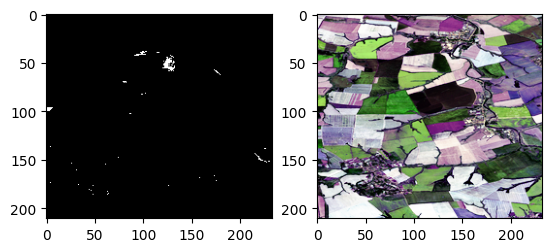

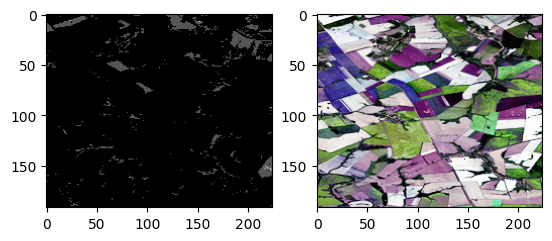

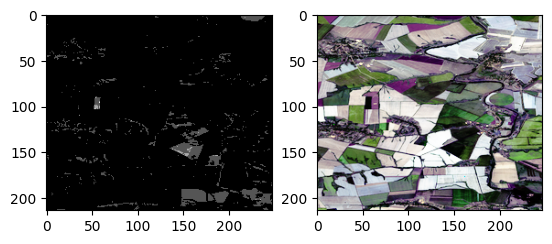

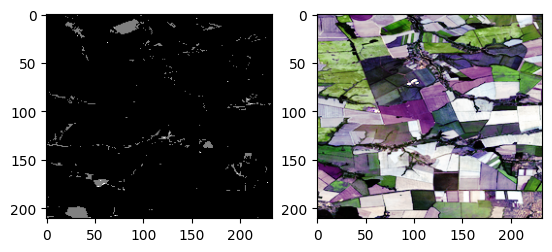

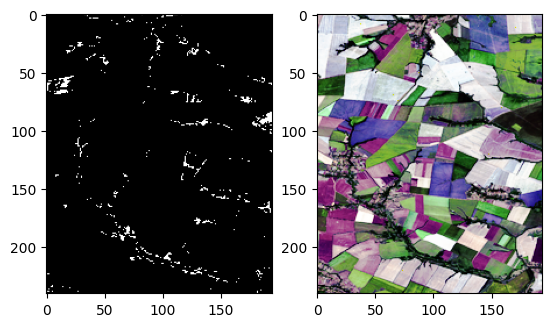

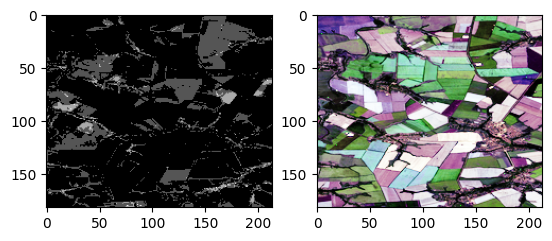

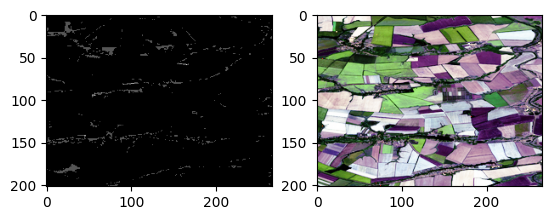

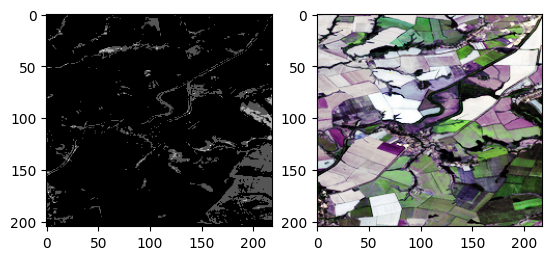

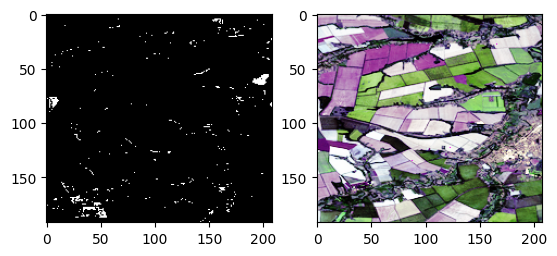

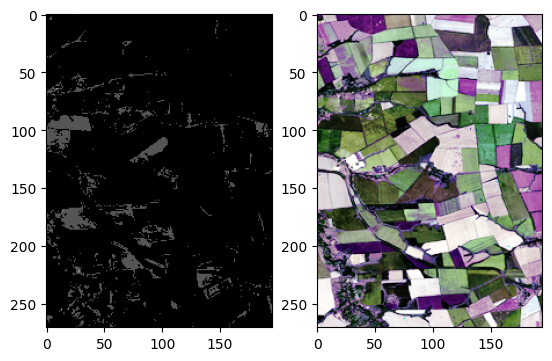

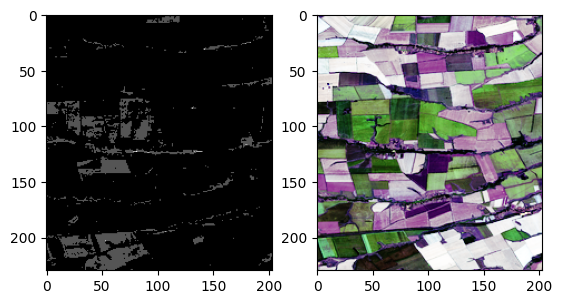

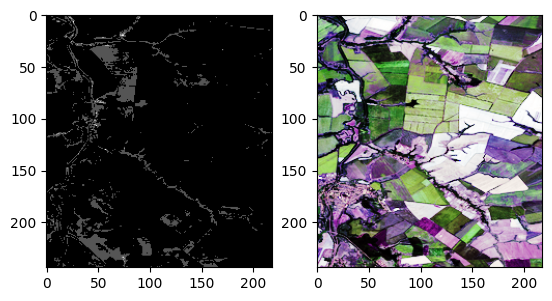

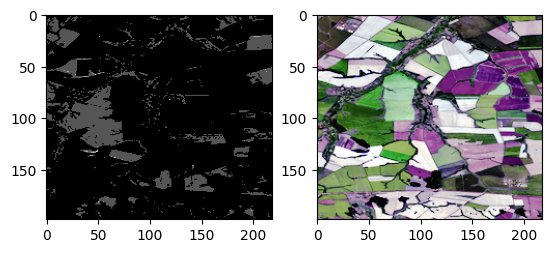

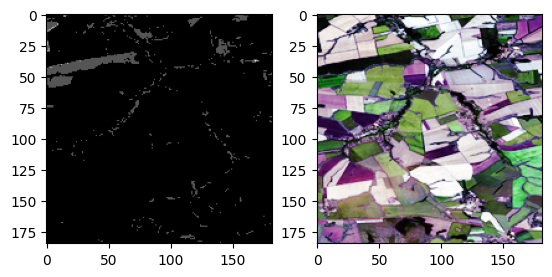

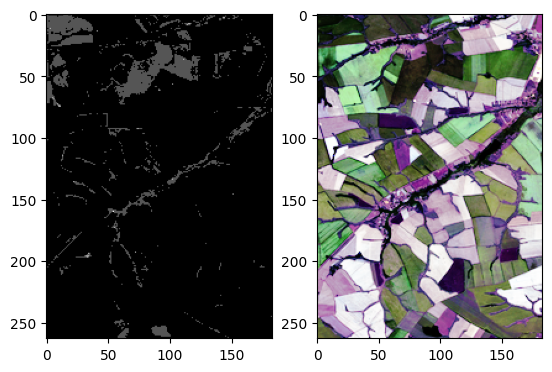

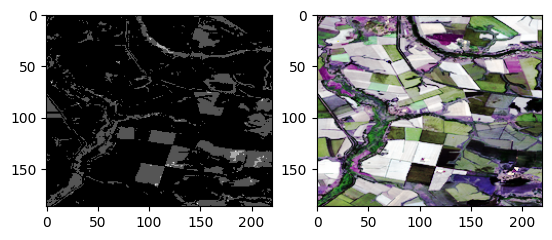

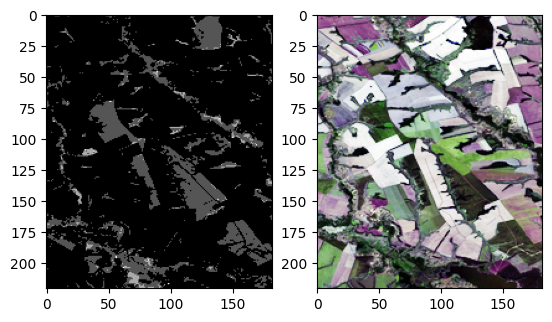

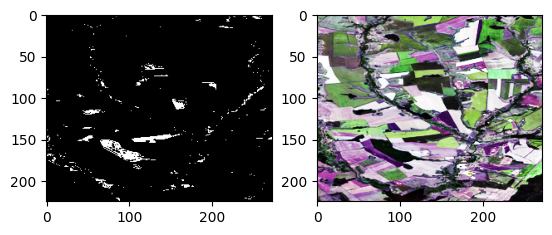

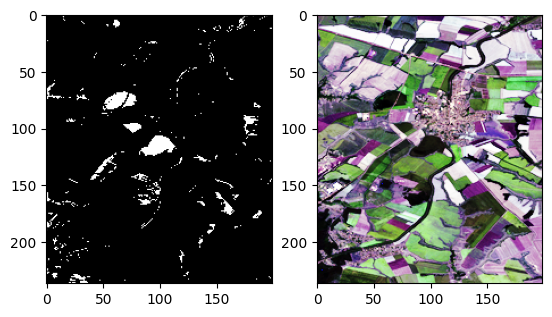

In [13]:
file_names =  ['crop_0_0_0000', 'crop_0_1_0000', 'crop_0_2_0000', 'crop_0_3_0000', 'crop_1_0_0000', 'crop_1_1_0000', 'crop_1_2_0000', 'crop_1_3_0000', 'crop_2_0_0000', 'crop_2_1_0000', 'crop_2_2_0000', 'crop_2_3_0000', 'crop_3_0_0000', 'crop_3_1_0000', 'crop_3_2_0000', 'crop_3_3_0000', 'crop_4_0_0000', 'crop_4_1_0000', 'crop_4_2_0000', 'crop_4_3_0000']
for j in range(19):
    img = scenes[j]
    name = file_names[j]
    plt.subplot(1, 2, 1)  # row 1, column 2, count 1
    i = calcus_RVI(img.r, img.nir, True)
    #i = i/np.max(i)
    plt.imshow(i, cmap='gray')
    plt.savefig(r"C:\Users\Maria Smirnova\Desktop\Проекты\LDT\rivers_masks\\" + name + r".png", dpi=300)
    #plt.colorbar()
    
    plt.subplot(1, 2, 2)  # row 1, column 2, count 1
    imshow(img.img, 'r, g, b', True)
    #plt.imshow(calcus_RVI(img.r, img.nir))
    #plt.colorbar()
    #plt.show()
    plt.show()

    ret,thresh = cv2.threshold(i,1,255,cv2.THRESH_BINARY)
    plt.imsave(base_path + '\\rivers\\' + name + r".png", thresh, cmap='gray', dpi=300)
    #print(thresh1)
    #plt.imshow(thresh1)
    plt.show()